# Multi-Armed Bandits Part 2

## UCB, Gradient Bandits, and Nonstationary Problems

In the last post we developed the theory and motivation behind multi-armed bandit problems in general as well as specific algorithms for solving those problems. I'm aware of over a dozen different methods and ways to go about solving bandit problems (I even found a website devoted to bandit algorithms!), but I'm going to stick (for now) with those discussed in Sutton's book, Reinforcement Learning: An Introduction.

## TL;DR

Here, we explore Upper Confidence Bound methods, gradient bandits, and nonstationary problems and provide algorithms for addressing these.

## Bandit Problems

As a quick refresher on bandit problems in general, we have a "bandit" which can be thought of like a slot machine with many different arms to pull. We call our selection of arm an action and we get a different payout or reward depending on which action we take. The goal is to maximize our reward over N
many pulls (in this case, we'll try 1,000 times). The challenge is to determine what the best action to take is, and to figure it out quickly. The sooner we can find the best, the more we can exploit that action and rake in the rewards.
This is often represented by a Q-value, which denotes the expected reward we get from each action. We learn about our bandits (environment) through interacting with it and gaining experience, and with each interaction we can update our Q-values. Often times these Q-values are represented as a function, Qn(a) where Q is the expected value given by action a for time step or iteration n. The solutions that we enumerate below are just different ways to estimate Qn(a).
For more details, check the previous post.

## Upper Confidence Bound Bandit

The first bandit strategy we'll examine is known as the Upper-Confidence-Bound method (UCB) which attempts to explore the action space based on the uncertainty or variance in a
's value. In this approach, the algorithm is forced to search based on taking some random action. It doesn't take any expectations into account or try to find values which are more likely to be rewarding; UCB fills this void.
The selection critera is given as:
$$A_n≐\arg\max_a(Q_n(a)+c\sqrt{\frac{\log(n)}{N_n(a)}})$$
Where Nn(a) denotes the number of times a has been selected thus far and c>0 controls the rate of exploration.
The squareroot term in the equation, is an estimate of the variance of the value of a. If a has yet to be explored, we have no information regarding it, thus it has an infinite variance and will be selected (depending on whether or not other actions remain unexplored). This is why if $N_n(a_1)=0$, then a1 is taken to be a maximizing action for the algorithm to explore as the expected value becomes infinite. On the other hand, each selection increases the value of t in the numerator, making it larger and again increasing the uncertainty of those actions which have not been selected. It increases logarthmically, so it does slow with time causing the other actions to be selected less frequently as more information develops.
Practically speaking, that infinite value when Nn(a)=0 is problematic and will raise errors in Python. We can get around this by initializing all of our action-count values to 1 such that $N_0(a)=1,\forall a$. This will avoid division by zero and result in the same solution when the number of actions taken is large.
With that caveat, let's implement it with our k-bandit problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class ucb_bandit:
    '''
    Upper Confidence Bound k-bandit problem
    
    Inputs 
    ============================================
    k: number of arms (int)
    c:
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    def __init__(self, k, c, iters, mu='random'):
        # Number of arms
        self.k = k
        # Exploration parameter
        self.c = c
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 1
        # Step count for each arm
        self.k_n = np.ones(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)
        
        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages            
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)
        
    def pull(self):
        # Select action according to UCB Criteria
        a = np.argmax(self.k_reward + self.c * np.sqrt(
                (np.log(self.n)) / self.k_n))
            
        reward = np.random.normal(self.mu[a], 1)
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total
        self.mean_reward = self.mean_reward + (
            reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.k_n[a]
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
            
    def reset(self, mu=None):
        # Resets results while keeping settings
        self.n = 1
        self.k_n = np.ones(self.k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(self.k)
        if mu == 'random':
            self.mu = np.random.normal(0, 1, self.k)

Running the ucb_bandit class requires three arguments, the number of arms to pull (k), the exploration parameter (c), the number of iterations (iters), and optionally, the distribution of the rewards (by default the reward means are drawn from a normal distribution). We run this for 1,000 episodes and average the rewards 

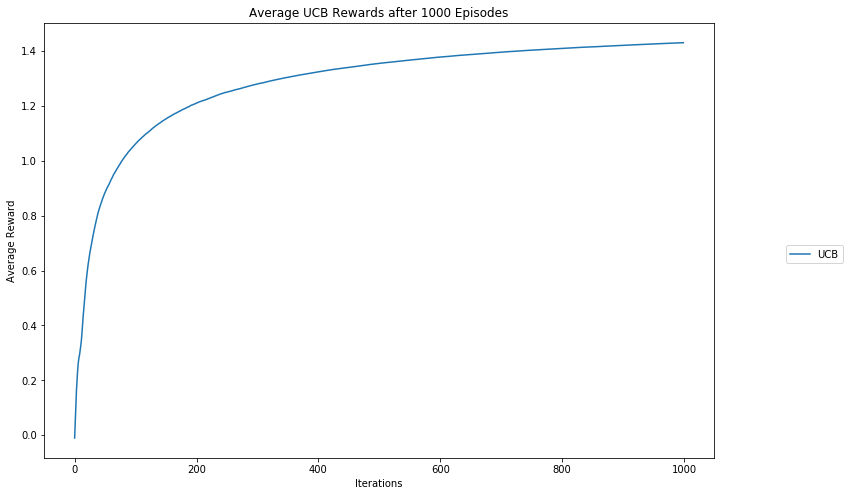

In [3]:
k = 10
iters = 1000

ucb_rewards = np.zeros(iters)
# Initialize bandits
ucb = ucb_bandit(k, 2, iters)

episodes = 1000
# Run experiments
for i in range(episodes): 
    ucb.reset('random')
    # Run experiments
    ucb.run()
    
    # Update long-term averages
    ucb_rewards = ucb_rewards + (
        ucb.reward - ucb_rewards) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(ucb_rewards, label="UCB")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average UCB Rewards after " 
          + str(episodes) + " Episodes")
plt.show()

The UCB approach is very effective as we'll see shortly when we explore gradient bandits.

## Gradient Bandits

Gradient algorithms take a different approach than the ones that we've seen thus far. This is a measure of the relative value of a given action over and above the other actions that are available. The algorithm learns a preference, $H_t(a)$
, which causes it to select the higher preferenced actions more frequently. The preferences are calculated using softmax.
$$\Pr(A_t=a)=\frac{e^{H_t(a)}}{\sum^k_{b=1}e^{H_t(a)}}=\pi_t(a)$$
There is a new term $\pi_t(a)$ which has been introduced here. This is essentially the probability of taking action a at time t. The algorithm is initialized with $H_0(a)=0,\forall a$, so that initially, all actions have an equal probability of selection.
In this case, the algorithm doesn't update the average of the rewards, but it updates the $H_t(a)$ value for each action using stochastic gradient ascent. Each time an action is taken, a reward is returned which is weighted by the probability of the action and the learning rate. This becomes the new value for $H_t(A_t)$. Because the probabilities are all relative to one another, they are all updated in turn. The procedure can be expressed as follows:
$$ H_{t+1}(A_t)=H_t(A_t)+\alpha(R_t−\hat{R}_t)(1−\pi_t(A_t)) $$
$$ H_{t+1}(a)=H_t(a)−\alpha(R_t−\hat{R}_t)π_t(a),\forall a \neq A_t $$
Now that we have the basics of the algorithm, we'll put a class together called grad_bandit that will allow us to evaluate this strategy.

In [5]:
def softmax(x):
    return np.exp(x - x.max()) / np.sum(np.exp(x - x.max()), axis=0)

class grad_bandit:
    
    def __init__(self, k, alpha, iters, mu='random'):
        # Number of arms
        self.k = k
        self.actions = np.arange(k)
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 1
        # Step count for each arm
        self.k_n = np.ones(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)
        # Initialize preferences
        self.H = np.zeros(k)
        # Learning rate
        self.alpha = alpha
        
        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages            
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)
            
    def softmax(self):
        self.prob_action = np.exp(self.H - np.max(self.H)) \
            / np.sum(np.exp(self.H - np.max(self.H)), axis=0)
        
    def pull(self):
        # Update probabilities
        self.softmax()
        # Select highest preference action
        a = np.random.choice(self.actions, p=self.prob_action)
            
        reward = np.random.normal(self.mu[a], 1)
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total
        self.mean_reward = self.mean_reward + (
            reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.k_n[a]
        
        # Update preferences
        self.H[a] = self.H[a] + \
            self.alpha * (reward - self.mean_reward) * (1 - self.prob_action[a])
        actions_not_taken = self.actions!=a
        self.H[actions_not_taken] = self.H[actions_not_taken] - \
            self.alpha * (reward - self.mean_reward) * self.prob_action[actions_not_taken]
            
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
            
    def reset(self, mu=None):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(self.k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(self.k)
        self.H = np.zeros(self.k)
        if mu == 'random':
            self.mu = np.random.normal(0, 1, self.k)

To implement, let's set up the environment as we did previously and include the UCB approach for comparison purposes. Like we did before, we'll randomly generate the average bandit return for each episode and run the experiment for 1,000 steps before resetting.

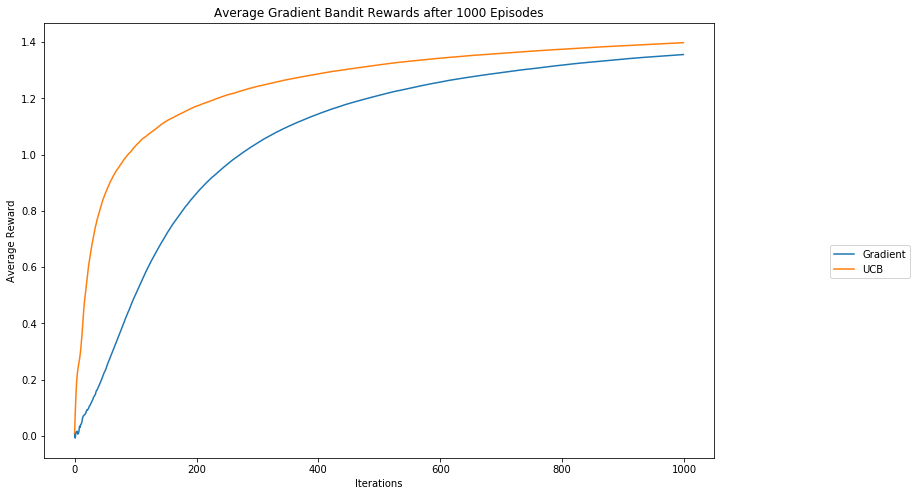

In [6]:
k = 10
iters = 1000
# Initialize bandits
grad = grad_bandit(k, 0.1, iters, mu='random')
ucb = ucb_bandit(k, 2, iters, mu=grad.mu)
ucb.mu = grad.mu

ucb_rewards = np.zeros(iters)
grad_rewards = np.zeros(iters)
opt_grad = 0
opt_ucb = 0

episodes = 1000
# Run experiments
for i in range(episodes):
    # Reset counts and rewards
    grad.reset('random')
    ucb.reset()
    ucb.mu = grad.mu
    
    # Run experiments
    grad.run()
    ucb.run()
    
    # Update long-term averages
    grad_rewards = grad_rewards + (
        grad.reward - grad_rewards) / (i + 1)
    ucb_rewards = ucb_rewards + (
        ucb.reward - ucb_rewards) / (i + 1)
    
    # Count optimal actions
    opt_grad += grad.k_n[np.argmax(grad.mu)]
    opt_ucb += ucb.k_n[np.argmax(ucb.mu)]
    
plt.figure(figsize=(12,8))
plt.plot(grad_rewards, label="Gradient")
plt.plot(ucb_rewards, label="UCB")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Gradient Bandit Rewards after " 
          + str(episodes) + " Episodes")
plt.show()

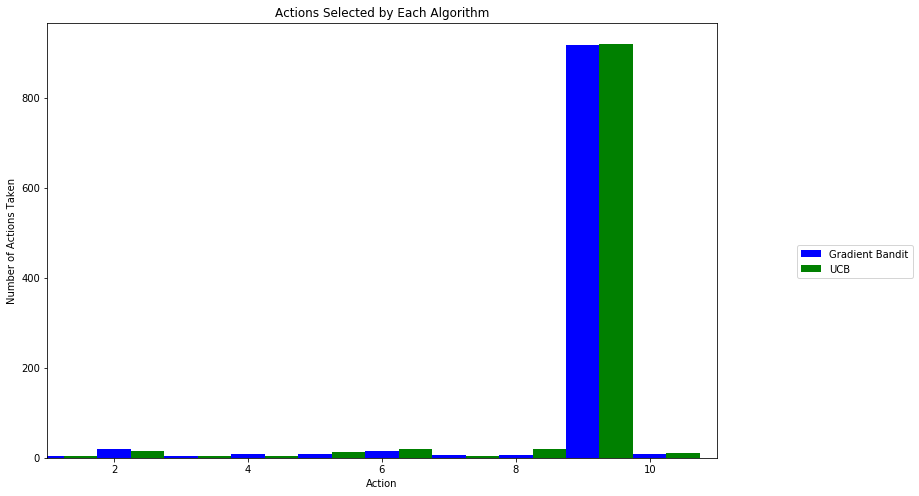

Percentage of actions selected:


In [7]:
import pandas as pd
bins = np.linspace(1, k, k)

plt.figure(figsize=(12,8))
plt.bar(bins, grad.k_n,
        width=0.5, color='b', 
        label="Gradient Bandit")
plt.bar(bins+0.5, ucb.k_n,
        width=0.5, color='g', 
        label="UCB")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlim([1,k+1])
plt.title("Actions Selected by Each Algorithm")
plt.xlabel("Action")
plt.ylabel("Number of Actions Taken")
plt.show()

opt_per = np.array([grad.k_n, ucb.k_n]) / iters * 100
df = pd.DataFrame(np.vstack([opt_per, grad.mu.reshape(-1, 1).T.round(2)]), 
                  index=["Grad", "UCB", "Expected Reward"],
                  columns=["a = " + str(x) for x in range(1, k+1)])
print("Percentage of actions selected:")
df

The gradient bandit outperformed the UCB approach on the final 1,000 pull run selecting the optimal action 69.6% of the time versus 49.6%. However, it didn't perform so well over the entire 1,000 episode experiment in comparison to the UCB:

In [8]:
print("Percentage of Optimal Selections for all episodes\nUCB: %.2f\nGradient: %.2f" 
      %(opt_ucb / (episodes * iters) * 100, 
        (opt_grad / (episodes * iters) * 100)))

Percentage of Optimal Selections for all episodes
UCB: 77.52
Gradient: 75.01


The gradient bandit performed comparably to the UCB bandit, although underperforming it for all episodes, it remains important to understand because it relates closely to one of the key concepts in machine learning: stochastic gradient ascent/descent (see section 2.8 of Reinforcement Learning: An Introduction for a derivation of this). This makes up the backbone of numerous optimization strategies as the algorithm adjusts weights in the direction of minimum or maximum gradient (depending on what is being optimized for). This has an especially powerful analog in reinforcement learning known as policy gradients which we'll cover in a future article.

## Nonstationary Bandits

All of the environments we've examined have been stationary environments: once the returns are selected, the means remain constant. Most real-world applications don't follow this pattern. Instead, the rewards drift over time meaning that the underlying reward function is dynamic. This behavior can cause your bandit's, once optimal behavior, to drift over time as the action degrades or other strategies become more beneficial. To deal with this, we can introduce a step-size parameter, $\beta$
to the equation where $0 < \beta \leq 1$. The parameter $\beta$, weights more recent observations more heavily than older observations and acts like a discount factor stretching back into the past. This leads to the result where our Q estimate can be written as:
$$Q_{n+1}=(1−\beta)nQ1+\sum_{i=1}^n \beta(1−\beta)n−1R_i$$
This is essentially a weighted average of all the past rewards and our initial estimate for Q and can be implemented in a similar update procedure. To see this in action, let's define our mean reward as a function of the total number of pulls. As such, the mean reward will drift with each action n. We'll make it a non-linear function as well just to make it a bit more interesting as the rewards shift.
$$R_n=IE[c⋅sin(n \pi N+c)]$$
This is a sample, nonstationary reward function such that the expectation of each pull is determined by some constant c, times the sin of our pull number n, times π divided by our total number of episodes, N.
We'll define a new bandit class, nonstationary_bandits with the option of using either ϵ-decay or ϵ-greedy methods. Also note, that if we set our β=1

, then we are implementing a non-weighted algorithm, so the greedy move will be to select the highest average action instead of the highest weighted action. Check back with the last post if you need a refresher on the ideas that underpin these bandit types.



In [9]:
class nonstationary_bandit:
    
    def __init__(self, k, beta, epsilon, iters, Q_init=None, c='random'):
        # Number of arms
        self.k = k
        self.actions = np.arange(k)
        self.epsilon = epsilon
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.ones(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)
        
        # Initialize estimates
        if not Q_init:
            self.Q_init = np.zeros(k)
        else:
            self.Q_init = Q_init
            
        self.Q = self.Q_init.copy()
        # Step size parameter
        self.beta = beta
        
        if type(c) == list or type(c).__module__ == np.__name__:
            # User-defined averages            
            self.c = np.array(c)
        elif c == 'random':
            # Draw value from normal distribution
            self.c = np.random.normal(0, 1, k)
        elif c == 'sequence':
            # Increase the mean for each arm by one
            self.c = np.linspace(0, k-1, k)
            
    def pull(self):        
        # Select highest average
        if self.beta == 1:
            a = np.argmax(self.k_reward)
        else:
            a = np.argmax(self.Q)
        # Possibly take random action
        p = np.random.rand()
        if self.epsilon == 'decay':
            if p < 1 / (1 + self.n):
                a = np.random.choice(self.k)
        else:
            if p < self.epsilon:
                a = np.random.choice(self.k)
        
        exp_reward = self.c[a] + np.sin(self.n * np.pi / self.iters + self.c[a])
        
        reward = np.random.normal(exp_reward, 1)
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total
        self.mean_reward = self.mean_reward + (
            reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.k_n[a]
        
        # Update Q-values
        self.Q[a] += self.beta * (reward - self.Q[a])
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
            
    def reset(self, mu=None):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(self.k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(self.k)



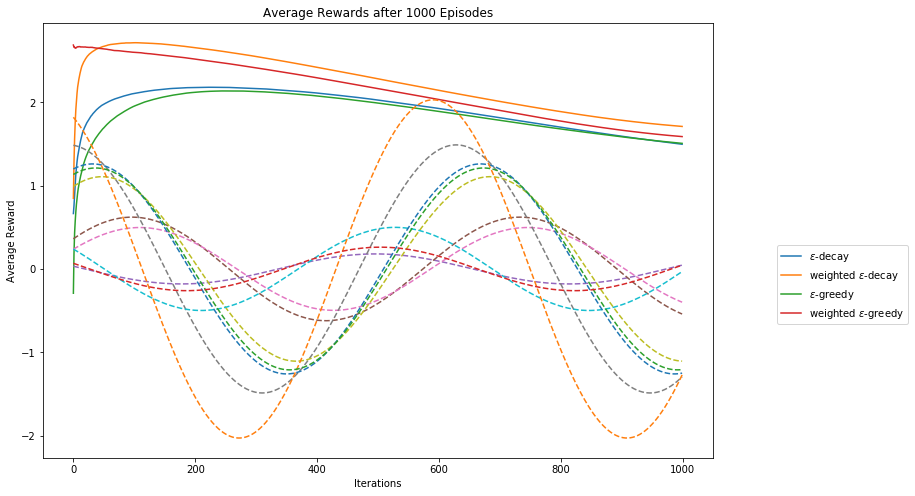

In [10]:
k = 10
iters = 1000
# Initialize bandits
ns_eps_decay = nonstationary_bandit(k, 1, 'decay', iters)
ns_eps_decay_weighted = nonstationary_bandit(k, 0.1, 'decay', iters, c=ns_eps_decay.c)
ns_eps_greedy = nonstationary_bandit(k, 1, 0.1, iters, c=ns_eps_decay.c)
ns_eps_greedy_weighted = nonstationary_bandit(k, 0.1, 0.1, iters, c=ns_eps_decay.c)

ns_eps_decay_rewards = np.zeros(iters)
ns_eps_decay_w_rewards = np.zeros(iters)
ns_eps_greedy_rewards = np.zeros(iters)
ns_eps_greedy_w_rewards = np.zeros(iters)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Reset counts and rewards
    ns_eps_decay.reset()
    ns_eps_decay_weighted.reset()
    ns_eps_greedy.reset()
    ns_eps_greedy_weighted.reset()
    
    # Run experiments
    ns_eps_decay.run()
    ns_eps_decay_weighted.run()
    ns_eps_greedy.run()
    ns_eps_greedy_weighted.run()
    
    # Update long-term averages
    ns_eps_decay_rewards = ns_eps_decay_rewards + (
        ns_eps_decay.reward - ns_eps_decay_rewards) / (i + 1)
    ns_eps_decay_w_rewards = ns_eps_decay_w_rewards + (
        ns_eps_decay_weighted.reward - ns_eps_decay_w_rewards) / (i + 1)
    ns_eps_greedy_rewards = ns_eps_greedy_rewards + (
        ns_eps_greedy.reward - ns_eps_greedy_rewards) / (i + 1)
    ns_eps_greedy_w_rewards = ns_eps_greedy_w_rewards + (
        ns_eps_greedy_weighted.reward - ns_eps_greedy_w_rewards) / (i + 1)
    
x = np.arange(iters) * np.pi / iters
plt.figure(figsize=(12,8))
plt.plot(ns_eps_decay_rewards, label=r"$\epsilon$-decay")
plt.plot(ns_eps_decay_w_rewards, label=r"weighted $\epsilon$-decay")
plt.plot(ns_eps_greedy_rewards, label=r"$\epsilon$-greedy")
plt.plot(ns_eps_greedy_w_rewards, label=r"weighted $\epsilon$-greedy")
for c in ns_eps_decay.c:
    plt.plot(c * np.sin(x * np.pi + c), '--')

plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Rewards after " 
          + str(episodes) + " Episodes")
plt.show()

The discounting helps the weighted ϵ algorithms outperform their non-weighted counterparts. Overall, none are spectacular, but it is very difficult to maintain high returns when the underlying reward functions are changing; it creates an aura of uncertainty.
See if some of the other bandit strategies (e.b. UCB or gradient bandits) can perform better, or how different β
values affect the algorithms. Maybe keeping a higher exploration rate - or determining a new exploration criteria - could help the algorithm to adjust. There are numerous options out there with various pros and cons, but no matter what, I think bandit problems are interesting problems to solve and serve as a great intro to some of the topics of reinforcement learning.